PCA

conda create -n pca --> 
conda activate pca

In [2]:
%pip install torch
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [2]:
# Temporary fix to kernel not responding
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Import necessary libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def perform_svd(data):
    # Convert the data into a PyTorch tensor
    tensor_data = torch.Tensor(data.values)

    # Compute the SVD where S is the eigenvalues and V is the eigenvectors
    U, S, V = torch.linalg.svd(tensor_data)

    return U, S, V, tensor_data

def display_shape(S, V):
    print("Shape of eigenvalues (S):", S.shape)
    print("Shape of eigenvectors (V):", V.shape)

Perform PCA to the data you choose!

In [4]:
epsilon=20

folder_path = f'epsilon{epsilon}/'
file_path_t = f'../{folder_path}/test.data'
file_path_v = f'../{folder_path}/val.data'
file_path_s = f'../{folder_path}/gene.data'

In [5]:
from torch.utils.data import Dataset

# Define a custom dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Load the real data
data_t = pd.read_csv(file_path_t, sep=" ", header=None)
data_t = torch.unique(torch.Tensor(data_t.values), dim=0)
data_t = pd.DataFrame(data_t)
labels_t = torch.ones(len(data_t))  # Label real data with 1

data_v = pd.read_csv(file_path_v, sep=" ", header=None)
data_v = torch.unique(torch.Tensor(data_v.values), dim=0)
data_v = pd.DataFrame(data_v)
labels_v = torch.ones(len(data_v))  # Label real data with 1

# Load the synthetic data
data_s = pd.read_csv(file_path_s, sep=" ", header=None)
data_s = torch.unique(torch.Tensor(data_s.values), dim=0)
data_s = pd.DataFrame(data_s)
labels_s = torch.zeros(len(data_s))  # Label synthetic data with 0

# Create datasets
dataset_r = TrajectoryDataset(pd.concat([data_t, data_v]).values, torch.cat([labels_t, labels_v]))
dataset_s = TrajectoryDataset(data_s.values, labels_s)

print("Real data shape:", dataset_r.data.shape)
print("Synthetic data shape:", dataset_s.data.shape)

Real data shape: (3380, 48)
Synthetic data shape: (9367, 48)


In [8]:
from torch.utils.data import DataLoader

def create_data_loader(dataset, batch_size, shuffle):
    return DataLoader(dataset, batch_size, shuffle)

# Example usage
relation_synthetic_to_real=dataset_s.data.shape[0]/dataset_r.data.shape[0]
#batch_size = dataset_nr.data.shape[0]/5
batch_size_r = 1500
batch_size_s = round(batch_size_r*relation_synthetic_to_real)
shuffle = True

# Create data loaders for dataset_nr and dataset_ns
data_loader_nr = create_data_loader(dataset_r, batch_size_r, shuffle)
data_loader_ns = create_data_loader(dataset_s, batch_size_s, shuffle)

# Extract data from data loaders
data_folded_r = next(iter(data_loader_nr))
data_folded_s = next(iter(data_loader_ns))

In [7]:
# Convert the numpy array to a pandas DataFrame
dataset_r_values = pd.DataFrame(dataset_r.data)

# Perform SVD on the converted DataFrame
U_r, S_r, V_r, real_data = perform_svd(dataset_r_values)

display_shape(S_r, V_r)

Shape of eigenvalues (S): torch.Size([48])
Shape of eigenvectors (V): torch.Size([48, 48])


In [8]:
# Convert the numpy array to a pandas DataFrame
dataset_s_values = pd.DataFrame(dataset_s.data)

# Perform SVD on the converted DataFrame
U_s, S_s, V_s, synthetic_data = perform_svd(dataset_s_values)

display_shape(S_s, V_s)

Shape of eigenvalues (S): torch.Size([48])
Shape of eigenvectors (V): torch.Size([48, 48])


Covariance matrix

In [9]:
def calculate_covariance_matrix(V, S):
    # Calculate the covariance matrix
    cov_matrix = torch.mm(torch.mm(V, torch.diag(S)), V.t())

    # Print the covariance matrix
    #print('Covariance Matrix:')
    #print(cov_matrix)
    #print('cov_matrix = ',cov_matrix.shape)


In [10]:
calculate_covariance_matrix(V_r, S_r)

calculate_covariance_matrix(V_s, S_s)

Variance of the components

In [11]:
def calculate_cumulative_variance(S):
    # Calculate the variance explained by each principal component
    variance_explained = (S ** 2) / torch.sum(S ** 2)

    # Calculate the cumulative variance explained
    cumulative_variance_explained = torch.cumsum(variance_explained, dim=0)

    return cumulative_variance_explained

In [12]:
cumulative_variance_real = calculate_cumulative_variance(S_r)
cumulative_variance_synthetic = calculate_cumulative_variance(S_s)

In [13]:
def scree_graph(cumulative_variance_real, cumulative_variance_synthetic):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance_real) + 1), cumulative_variance_real, linestyle='-', marker='x', color='red', label='Real Data')
    plt.plot(range(1, len(cumulative_variance_synthetic) + 1), cumulative_variance_synthetic, linestyle='-', marker='x', color='blue', label='Synthetic Data')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance')
    plt.legend()
    plt.title('Scree Graph')
    plt.show()

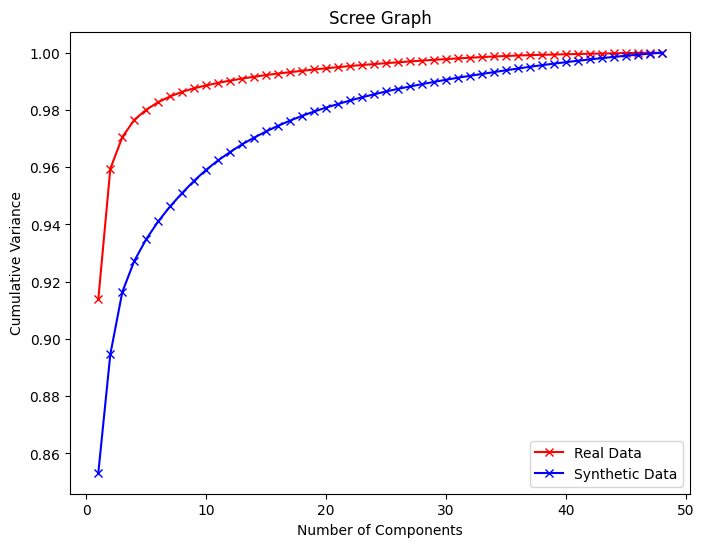

In [14]:
scree_graph(cumulative_variance_real, cumulative_variance_synthetic)

Decide: desired_variance = 1 - maximum information loss 

In [15]:
desired_variance = 0.99

In [16]:
def get_num_components(cumulative_variance_explained, desired_variance):
    num_components = torch.sum(cumulative_variance_explained < desired_variance) + 1
    return num_components.item()

# Not needed as we only project on the synthetic data
# num_components_needed_real = get_num_components(cumulative_variance_real, desired_variance)
# print("Number of principal components needed for a cumulative variance explained of", desired_variance, ":", num_components_needed_real, " components")


num_components_needed_syn = get_num_components(cumulative_variance_synthetic, desired_variance)
print("Number of principal components needed for a cumulative variance explained of", desired_variance, ":", num_components_needed_syn, " components")

Number of principal components needed for a cumulative variance explained of 0.99 : 30  components


In [17]:
import torch
# Project the real_data onto the plane formed by the principal components
new_coordinates_real = torch.matmul(real_data,V_s[:, :num_components_needed_syn])
labels_nr = torch.ones(len(dataset_r.data))  # Label real data with 1
dataset_nr = TrajectoryDataset(new_coordinates_real, labels_nr)

# Project the real_data onto the plane formed by the principal components
new_coordinates_synthetic = torch.matmul(synthetic_data,V_s[:, :num_components_needed_syn])
labels_ns = torch.ones(len(dataset_s.data))  # Label real data with 0
dataset_ns = TrajectoryDataset(new_coordinates_synthetic, labels_ns)

# Assuming dataset_nr.data and dataset_ns.data are torch.Tensor variables
torch.save(dataset_nr.data, f'../epsilon{epsilon}/dataset_nr.data')
torch.save(dataset_ns.data, f'../epsilon{epsilon}/dataset_ns.data')

print("Real data shape:", dataset_nr.data.shape)
print("Synthetic data shape:", dataset_ns.data.shape)

Real data shape: torch.Size([3380, 30])
Synthetic data shape: torch.Size([9367, 30])


In [18]:
# Plotting the real and synthetic new coordinates
def new_coordinates_comparison(new_coordinates_real, new_coordinates_synthetic):
    plt.figure(figsize=(8, 6))
    plt.scatter(new_coordinates_real[:, 0], new_coordinates_real[:, 1], label='Real', s=1)
    plt.scatter(new_coordinates_synthetic[:, 0], new_coordinates_synthetic[:, 1], label='Synthetic', s=1)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('New Coordinates on First and Second Principal Components')
    plt.legend()
    plt.show()

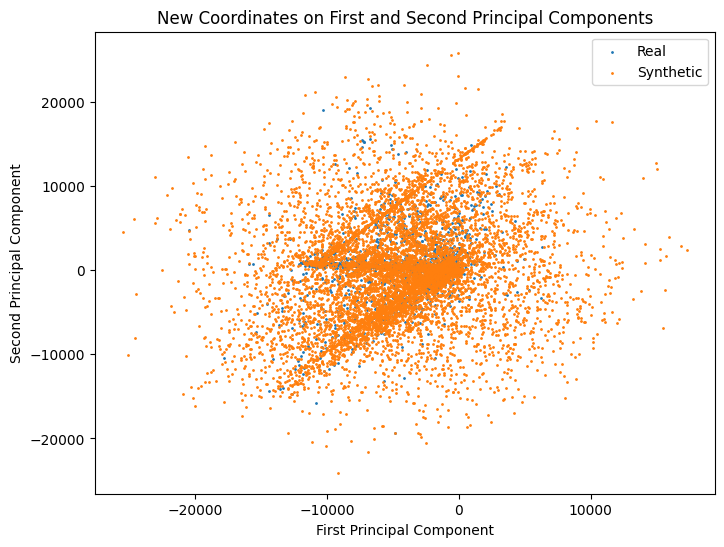

In [19]:
new_coordinates_comparison(dataset_nr.data, dataset_ns.data)

KNN

In [21]:
import torch

class KNN():
    def __init__(self, distance:str = 'euc') -> None:
        self.constellation = None
        self.dim = None
        self.available_dist = ['euc', 'sqd', 'max', 'cab']
        self.ensure_distance(distance)
        self.distance = distance
    
    def fit(self, constellation:torch.Tensor)-> None:
        self.constellation = constellation
        self.dim = len(self.constellation.shape)-1
    
    def set_distance(self, distance: str)-> None:
        self.ensure_distance(distance)
        self.distance = distance
    
    def ensure_distance(self, distance):
        if distance not in self.available_dist:
            raise NotAvailableFeature(f'Feature not available {distance}, currently only available distances: {self.available_dist}')
    
    def compute_distance(self, X:torch.Tensor)-> torch.Tensor:
        '''
        Computing distances from X to each point in the constellation depending on the self.distance value the metric will differ:
            - euc: Euclidean distance between points
            - sqd: Squared euclidean distance
            - max: Tchebychev distance (maximum metric)
            - cab: Taxicab distance or Manhattan distance
        '''
        if self.distance == self.available_dist[0]:
            dist = self.constellation.add( - X).pow(2).sum(dim=self.dim).pow(.5) 
        elif self.distance == self.available_dist[1]:
            dist = self.constellation.add( - X).pow(2).sum(dim=self.dim)
        elif self.distance == self.available_dist[2]:
            dist = torch.abs(self.constellation.add( - X)).max(dim=self.dim).values
        elif self.distance == self.available_dist[3]:
            dist = torch.abs(self.constellation.add( - X)).sum(dim=self.dim)
        return dist
    
    def kneighbours(self, X:torch.Tensor, k:int=4)-> tuple:
        '''
        Inputs:
        # X: A single trajectory that we want to check if it is similar to the original data.
        # k: the number of k nearest neighbours we want to see in the output
        Outputs:
        # dist: Distances to the first k-nearest neighbours
        # knn_indices: Indexes of the k-nearest neighbours
        '''
        if self.dim != None and self.dim>0:
            X = X.expand(self.constellation.shape) # Repeat the same two point traj N times until shape matches with the synthetic trajectories

            # Computing distance
            dist = self.compute_distance(X)
            # Getting the k nearest points
            knn_indices = dist.topk(k, largest=False, sorted=False)[1] # Getting the k smallest distances

            return dist[knn_indices], knn_indices
        else:
            raise ModelNotFit('The model has not been fit with the constellation or the constellation is empty. Before using model.kneighbours use model.fit with a propper constellation')

class ModelNotFit(Exception):
    def __init__(self, *args: object) -> None:
        super().__init__(*args)

class NotAvailableFeature(Exception):
    def __init__(self, *args: object) -> None:
        super().__init__(*args)

In [22]:
# Create an instance of the KNN class
knn = KNN()

# Fit the KNN model with the synthetic data
knn.fit(dataset_ns.data)

print('new_coordinates_real = ', dataset_nr.data.shape)

for trajectory in dataset_nr.data:
    dist, knn_indices = knn.kneighbours(trajectory, k=8)
    print('trajectory = ', trajectory)
    print('dist = ', dist)
    print('knn_indices = ', knn_indices)

new_coordinates_real =  torch.Size([3380, 30])
trajectory =  tensor([ 2.0058e+01,  3.4579e+01,  3.2316e-01, -4.9207e+01,  6.8087e+00,
         5.3505e+01, -1.2547e+02,  1.4567e+02,  7.5921e+01, -5.7589e+02,
         5.0069e+02,  5.0216e+02, -2.6554e+03,  3.0772e+03, -6.0574e+01,
         2.5306e+02, -2.4858e+03, -1.1130e+03,  1.2271e+03,  1.7190e+03,
         1.1787e+03, -2.1477e+02, -8.3530e+02, -9.0459e+02, -8.2900e+02,
        -5.9967e+02,  1.5606e+02,  6.0212e+02,  9.5852e+02,  1.3093e+03])
dist =  tensor([5781.5942, 5958.8706, 5961.9170, 5970.3896, 5996.3706, 5998.4746,
        6002.3076, 6004.4277])
knn_indices =  tensor([ 991,  278, 1266,  277,  623,  753,  488,  299])
trajectory =  tensor([  -121.4346,    175.8687,    332.8038,  -1027.4563,    875.7573,
           564.4500,  -1749.4548,   2789.0693,  -3978.6138,  10477.1045,
        -20046.9473,   9639.4111,   2317.3484,  -3713.9536,   9144.2900,
         15065.4180, -30443.8887,   1567.1970,   6267.7896,   7701.0693,
         